In [2]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 7.5 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=6caf80c23829b19c7f9219976ab6ff824d8a2af47dcec71686ff40c1ab7e7830
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
pip install hmmlearn

     |████████████████████████████████| 374 kB 4.8 MB/s 


In [4]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.mixture as mix

from hmmlearn.hmm import GaussianHMM
from google.colab import drive
%matplotlib inline

In [10]:
# Define the range of historical data
start_date = "1996-01-01"
end_date = "2021-01-01"

**Visualize each indicator**


[*********************100%***********************]  1 of 1 completed


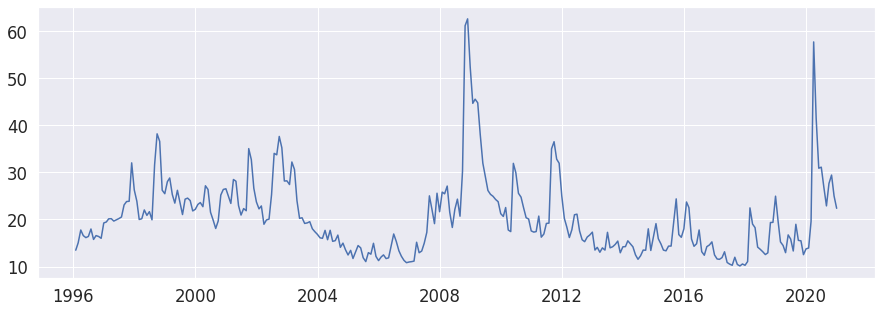

In [17]:
# VIX Data
vix = yf.download("^VIX", start_date, end_date)
vix = vix['Adj Close']
vix = pd.DataFrame(vix.resample('1M').mean())
plt.figure(figsize=(15,5))
plt.plot(vix)

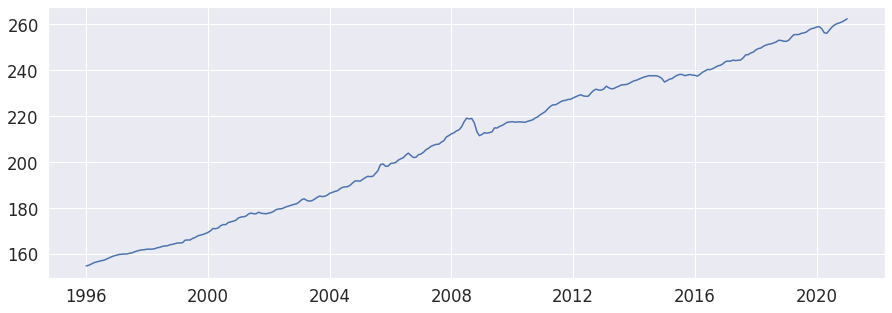

In [18]:
# CPI Data
cpi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FRE 7121/CPI.csv', index_col=0)
cpi.index = pd.to_datetime(cpi.index)

fig = plt.figure(figsize=(15,5))
plt.plot(cpi)
plt.show()

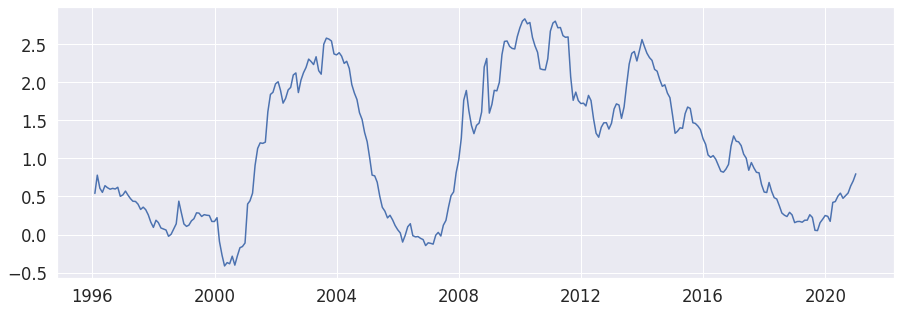

In [19]:
# T10Y2Y
ty = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FRE 7121/T10Y2Y.csv', index_col=0)
ty.index = pd.to_datetime(ty.index)
ty.drop(ty[ty['T10Y2Y']=='.'].index, inplace=True)
ty = pd.to_numeric(ty['T10Y2Y'])
ty = pd.DataFrame(ty.resample('1M').mean())

plt.figure(figsize=(15,5))
plt.plot(ty)

[*********************100%***********************]  1 of 1 completed


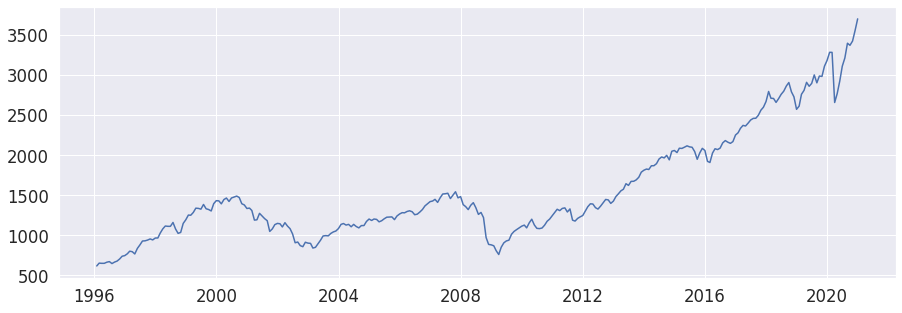

In [20]:
# S&P500
spx = yf.download('^GSPC', start_date, end_date)
spx = spx['Adj Close']
spx = pd.DataFrame(spx.resample('1M').mean())

plt.figure(figsize=(15,5))
plt.plot(spx)

**Fit the model to detect regimes for each indicator**

VIX

Means and vars of each hidden state
0th hidden state
mean =  [3.14490036]
var =  [0.09325533]

1th hidden state
mean =  [2.67410318]
var =  [0.03464971]



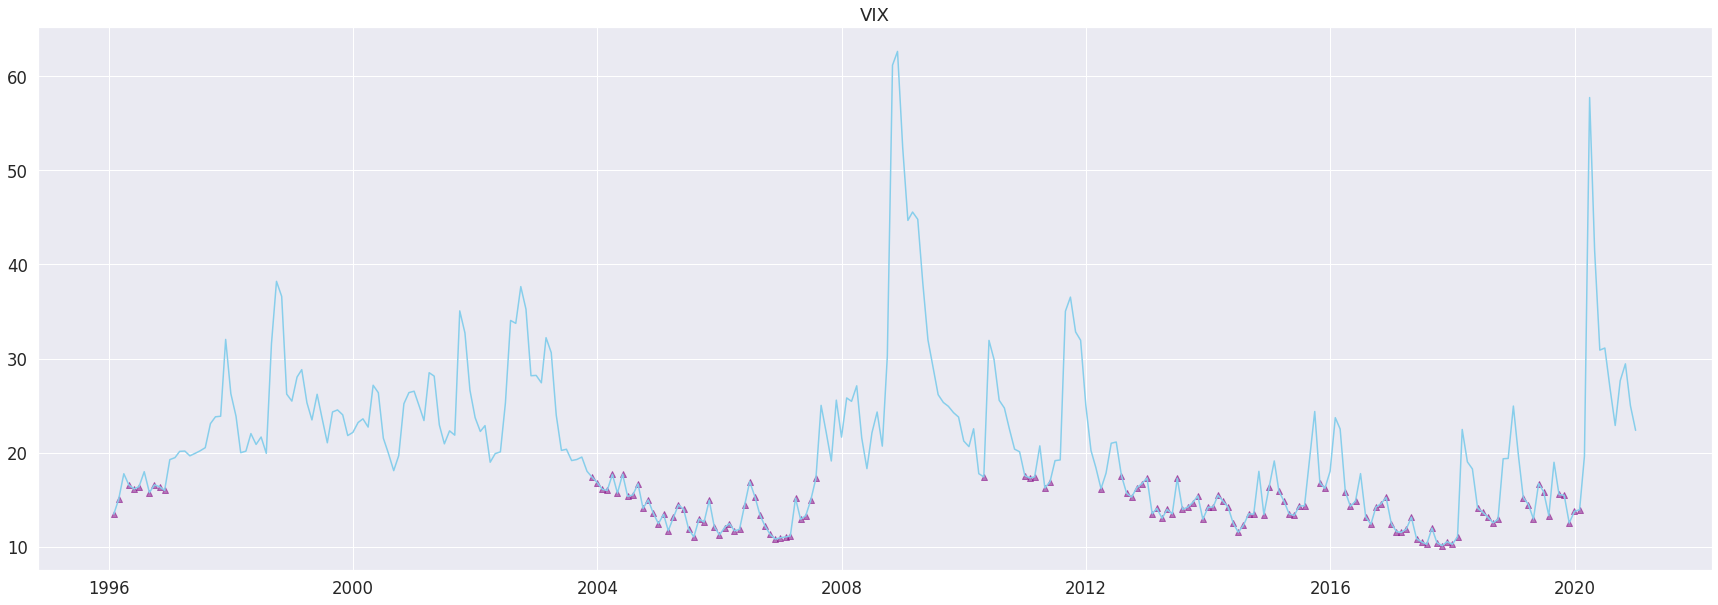

In [34]:
# Fit the model
X = vix
Y = np.log(vix)
model = mix.GaussianMixture(n_components=2, covariance_type="full", n_init=50, random_state=7).fit(Y)
hidden_state = model.predict(Y)

# Generate all states
sns.set(font_scale=1.5)
states_vix = (pd.DataFrame(hidden_state, columns=['states'], index=X.index)
          .join(X, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'ATE'}))
vix_states = states_vix.copy()
# Combine states and each day's price
states_vix['new'] = states_vix['states'] * states_vix['Adj Close']
states_vix.drop(['states'], axis=1, inplace=True)
states_vix.set_index('Date', drop=True, inplace=True)

# Compute the statistics
print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

# Visualize uperward trends
plt.figure(figsize=(30, 10))
plt.title('VIX')
plt.plot(states_vix.index, states_vix['Adj Close'], color='skyblue', label='VIX')
plt.scatter(states_vix.index[states_vix['new']==states_vix['Adj Close']], states_vix[states_vix['new']==states_vix['Adj Close']]['new'], alpha=0.5, marker='^', color='purple', label='States')
plt.show()

CPI

Means and vars of each hidden state
0th hidden state
mean =  [5.442446]
var =  [0.00573234]

1th hidden state
mean =  [5.16531041]
var =  [0.0059331]



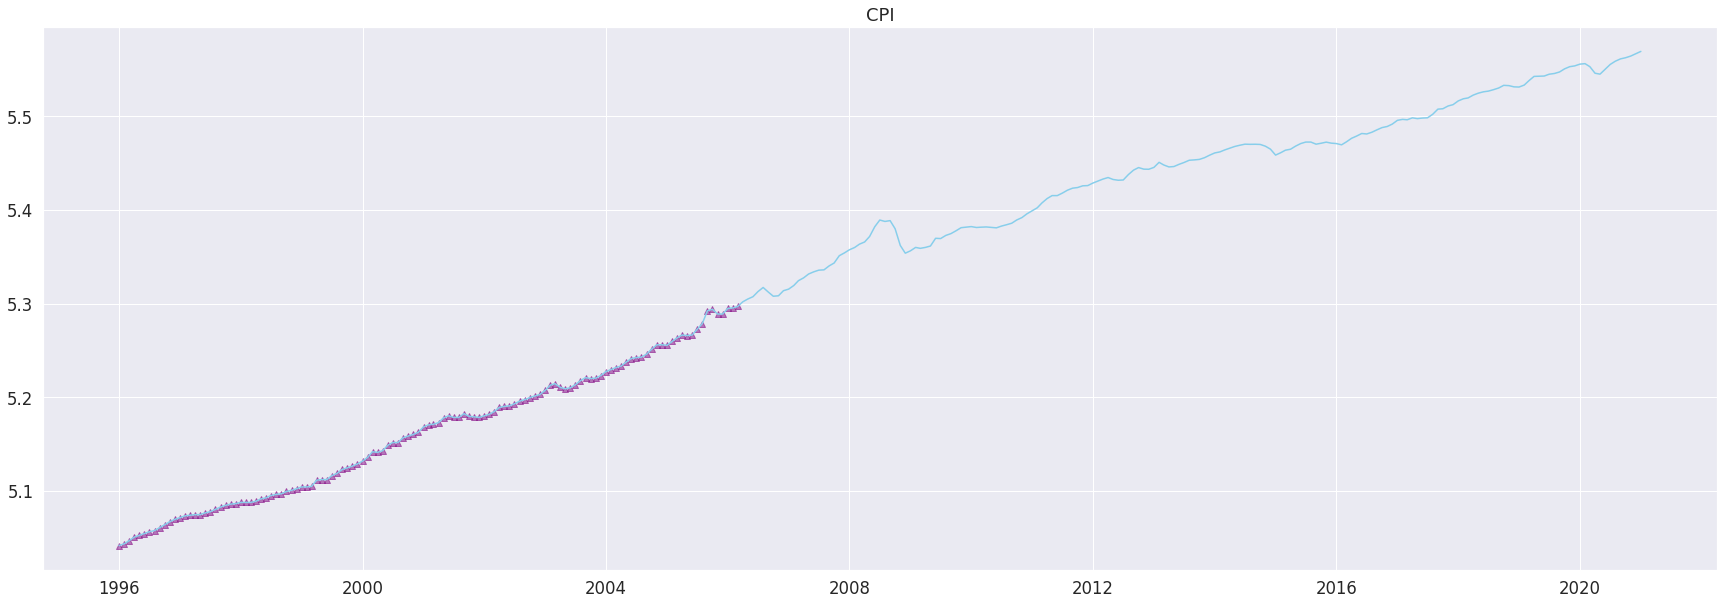

In [36]:
# Fit the model
cpi_temp = cpi
Y = np.log(cpi_temp)
model = mix.GaussianMixture(n_components=2, covariance_type="full", n_init=10, random_state=7).fit(Y)
hidden_state = model.predict(Y)

# Generate all states
sns.set(font_scale=1.5)
states_cpi = (pd.DataFrame(hidden_state, columns=['states'], index=Y.index)
          .join(Y, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'ATE'}))
cpi_states = states_cpi.copy()

# Combine states and each day's price
states_cpi['new'] = states_cpi['states'] * states_cpi['CPIAUCSL']
states_cpi.drop(['states'], axis=1, inplace=True)
states_cpi.set_index('DATE', drop=True, inplace=True)

# Compute the statistics
print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

# Visualize uperward trends
plt.figure(figsize=(30, 10))
plt.title('CPI')
plt.plot(states_cpi.index, states_cpi['CPIAUCSL'], color='skyblue', label='CPI')
plt.scatter(states_cpi.index[states_cpi['new']==states_cpi['CPIAUCSL']], states_cpi[states_cpi['new']==states_cpi['CPIAUCSL']]['new'], alpha=0.5, marker='^', color='purple', label='States')
plt.show()

T10Y2Y

Means and vars of each hidden state
0th hidden state
mean =  [1.89065396]
var =  [0.27335433]

1th hidden state
mean =  [0.31157734]
var =  [0.10926882]



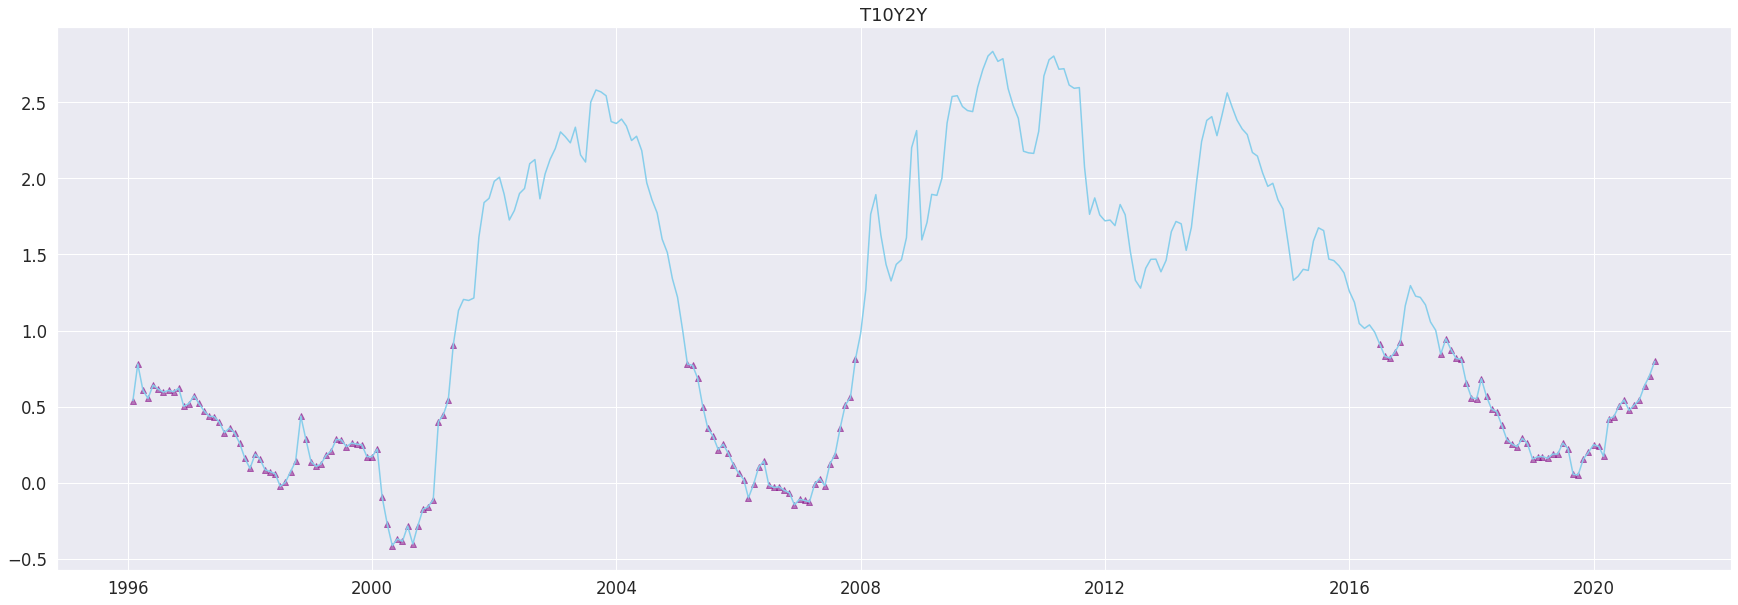

In [37]:
# Fit the model
ty_temp = ty
Y = ty_temp
model = mix.GaussianMixture(n_components=2, covariance_type="full", n_init=10, random_state=7).fit(Y)
hidden_state = model.predict(Y)

# Generate all states
sns.set(font_scale=1.5)
states_ty = (pd.DataFrame(hidden_state, columns=['states'], index=Y.index)
          .join(Y, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'ATE'}))
ty_states = states_ty.copy()

# Combine states and each day's price
states_ty['new'] = states_ty['states'] * states_ty['T10Y2Y']
states_ty.drop(['states'], axis=1, inplace=True)
states_ty.set_index('DATE', drop=True, inplace=True)

# Compute the statistics
print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

# Visualize uperward trends
plt.figure(figsize=(30, 10))
plt.title('T10Y2Y')
plt.plot(states_ty.index, states_ty['T10Y2Y'], color='skyblue', label='T10Y2Y')
plt.scatter(states_ty.index[states_ty['new']==states_ty['T10Y2Y']], states_ty[states_ty['new']==states_ty['T10Y2Y']]['new'], alpha=0.5, marker='^', color='purple', label='States')
plt.show()

SPX

Means and vars of each hidden state
0th hidden state
mean =  [7.80857529]
var =  [0.03914345]

1th hidden state
mean =  [7.06785494]
var =  [0.05782456]



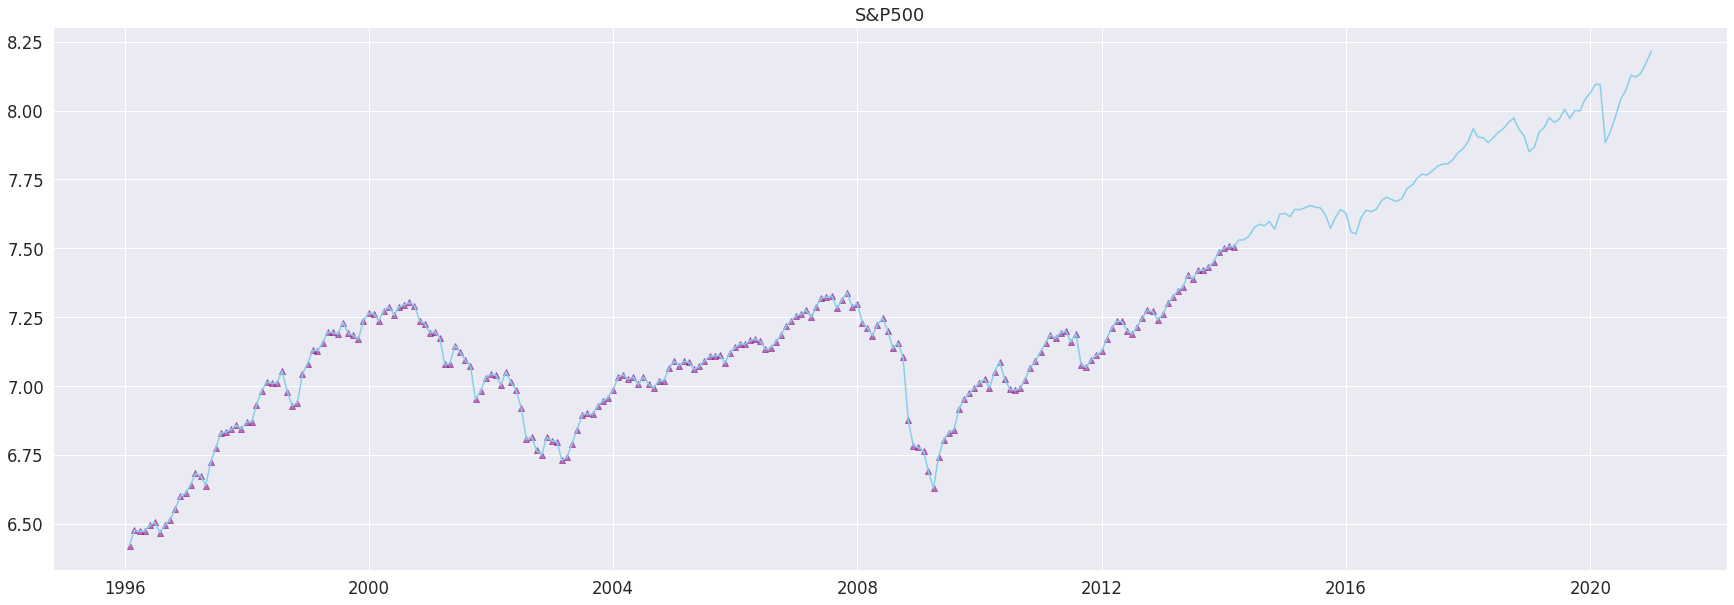

In [39]:
# Fit the model
spx_temp = spx
Y = np.log(spx_temp)
model = mix.GaussianMixture(n_components=2, covariance_type="full", n_init=10, random_state=7).fit(Y)
hidden_state = model.predict(Y)

# Generate all states
sns.set(font_scale=1.5)
states_spx = (pd.DataFrame(hidden_state, columns=['states'], index=Y.index)
          .join(Y, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'ATE'}))
spx_states = states_spx.copy()

# Combine states and each day's price
states_spx['new'] = states_spx['states'] * states_spx['Adj Close']
states_spx.drop(['states'], axis=1, inplace=True)
states_spx.set_index('Date', drop=True, inplace=True)

# Compute the statistics
print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

# Visualize uperward trends
plt.figure(figsize=(30, 10))
plt.title('S&P500')
plt.plot(states_spx.index, states['Adj Close'], color='skyblue', label='S&P500')
plt.scatter(states_spx.index[states_spx['new']==states_spx['Adj Close']], states_spx[states_spx['new']==states_spx['Adj Close']]['new'], alpha=0.5, marker='^', color='purple', label='States')
plt.show()

**Prediction on AAPL**

In [35]:
# Construct states for all indicators
vix_states.set_index(['Date'], drop=True, inplace=True)
vix_states = vix_states['states']
vix_states.columns = ['VIX']
vix_states = pd.DataFrame(vix_states)

In [38]:
ty_states.set_index('DATE', drop=True, inplace=True)
ty_states = ty_states['states']
ty_states.columns = ['TY10Y2Y']
ty_states = pd.DataFrame(ty_states)

In [40]:
spx_states.set_index('Date', drop=True, inplace=True)
spx_states = spx_states['states']
spx_states.columns = ['SPX']
spx_states = pd.DataFrame(spx_states)

In [41]:
all_states = pd.concat([vix_states, ty_states, spx_states], axis=1)

In [42]:
all_states.columns = ['VIX', 'T10Y2Y', 'SPX']
all_states.head(10)

,VIX,T10Y2Y,SPX
1996-01-31,1,1,1
1996-02-29,1,1,1
1996-03-31,0,1,1
1996-04-30,1,1,1
1996-05-31,1,1,1
1996-06-30,1,1,1
1996-07-31,0,1,1
1996-08-31,1,1,1
1996-09-30,1,1,1
1996-10-31,1,1,1


In [43]:
test_states = all_states['2010':'2020']

In [44]:
# Find regimes
same_date = []
for i in range(len(test_states)):
  temp = all_states[:len(test_states)+i]
  inverse_all = temp.iloc[::-1]
  for j in range(len(inverse_all)):
    if (test_states.iloc[i]['VIX'] == inverse_all.iloc[j]['VIX']):
      same_date.append(inverse_all.iloc[j].name)
      break

In [45]:
same_date = pd.to_datetime(same_date)

In [46]:
test_states['DATE'] = same_date
test_states.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,VIX,T10Y2Y,SPX,DATE
2010-01-31,0,0,1,2003-10-31
2010-02-28,0,0,1,2003-10-31
2010-03-31,0,0,1,2003-10-31
2010-04-30,1,0,1,2007-03-31
2010-05-31,0,0,1,2003-10-31
2010-06-30,0,0,1,2003-10-31
2010-07-31,0,0,1,2003-10-31
2010-08-31,0,0,1,2003-10-31
2010-09-30,0,0,1,2007-08-31
2010-10-31,0,0,1,2007-09-30


In [47]:
final_date = []
for item in same_date:
  if (item.month < 10):
    date = str(item.year) + '-' + '0' + str(item.month) + '-' + str(item.day)
  else:
    date = str(item.year) + '-' + str(item.month) + '-' + str(item.day)
  final_date.append(date)

In [48]:
aapl = yf.download('AAPL', "1996-01-01", "2021-01-01")
aapl = aapl['Close']
aapl = pd.DataFrame(aapl)
aapl['shift'] = aapl.shift(-22)

[*********************100%***********************]  1 of 1 completed


In [50]:
test_states

,VIX,T10Y2Y,SPX,DATE
2010-01-31,0,0,1,2003-10-31
2010-02-28,0,0,1,2003-10-31
2010-03-31,0,0,1,2003-10-31
2010-04-30,1,0,1,2007-03-31
2010-05-31,0,0,1,2003-10-31
...,...,...,...,...
2020-08-31,0,1,0,2016-06-30
2020-09-30,0,1,0,2016-06-30
2020-10-31,0,1,0,2016-06-30
2020-11-30,0,1,0,2016-06-30


In [51]:
# Combine the dataset
temp = test_states

In [54]:
temp['Action'] = 0
temp['Price'] = 0
temp.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,VIX,T10Y2Y,SPX,DATE,Action,Price
2010-01-31,0,0,1,2003-10-31,0,0
2010-02-28,0,0,1,2003-10-31,0,0
2010-03-31,0,0,1,2003-10-31,0,0
2010-04-30,1,0,1,2007-03-31,0,0
2010-05-31,0,0,1,2003-10-31,0,0
2010-06-30,0,0,1,2003-10-31,0,0
2010-07-31,0,0,1,2003-10-31,0,0
2010-08-31,0,0,1,2003-10-31,0,0
2010-09-30,0,0,1,2007-08-31,0,0
2010-10-31,0,0,1,2007-09-30,0,0


In [55]:
# 1 is pos, 0 is neg
for i in range(len(temp)):
  if temp['DATE'][i] in aapl.index:
    row = aapl.loc[temp['DATE'][i]]
    if row[0] < row[1]:
      temp['Action'][i] = 1
      temp['Price'][i] = row[0]
    else:
      temp['Action'][i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/py

In [57]:
# Visualize the result
aapl_plt = yf.download('AAPL', '2010-01-31', '2020-12-31')
aapl_plt = aapl_plt['Close']
aapl_plt = pd.DataFrame(aapl_plt)

[*********************100%***********************]  1 of 1 completed


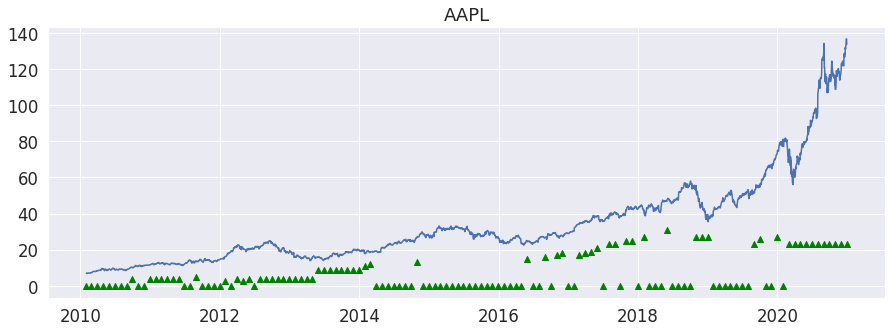

In [67]:
plt.figure(figsize=(15,5))
plt.plot(aapl_plt)
plt.scatter(temp.index, temp['Price'], marker='^', c='green')
plt.title('AAPL')
plt.show()